In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.ndimage import convolve
from sklearn.feature_extraction.image import extract_patches_2d


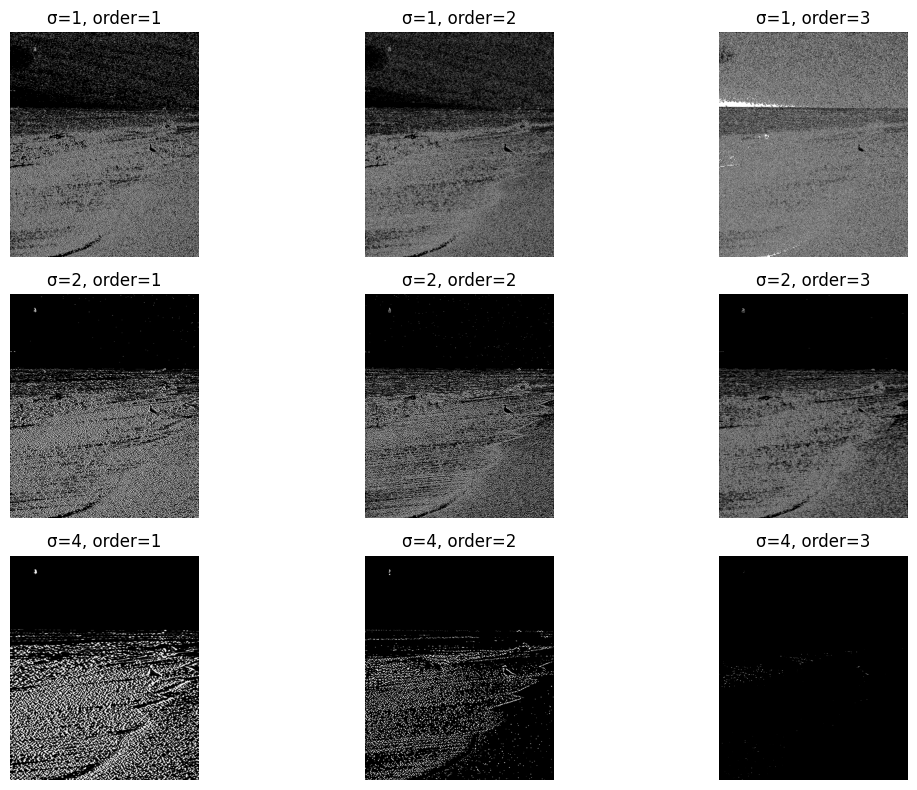

In [26]:
# Define scales for Gaussian filters
scales = [1, 2, 4]

# Function to generate Gaussian derivative kernels
def gaussian_derivative_kernels(sigma, order):
    """ Generate Gaussian derivative filters for a given scale (sigma) and derivative order """
    size = int(6 * sigma + 1)  # Ensure the filter size is large enough
    if size % 2 == 0:
        size += 1  # Keep the filter size odd
    x = np.linspace(-size//2, size//2, size)
    gaussian = np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

    if order == 1:
        kernel = -x / (sigma**2) * gaussian
    elif order == 2:
        kernel = (x**2 - sigma**2) / (sigma**4) * gaussian
    elif order == 3:
        kernel = (x**3 - 3 * x * sigma**2) / (sigma**6) * gaussian
    else:
        raise ValueError("Only orders 1, 2, and 3 are supported")

    return kernel

# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Apply filter bank and compute responses
responses = []
for sigma in scales:
    for order in [1, 2, 3]:
        kernel = gaussian_derivative_kernels(sigma, order)
        filtered_image = ndimage.convolve1d(image, kernel, axis=0)  # Apply filter in y-direction
        filtered_image = ndimage.convolve1d(filtered_image, kernel, axis=1)  # Apply filter in x-direction
        responses.append((sigma, order, filtered_image))

# Display the filtered images
fig, axes = plt.subplots(len(scales), 3, figsize=(12, 8))
for i, (sigma, order, response) in enumerate(responses):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(response, cmap='gray')
    axes[row, col].set_title(f"σ={sigma}, order={order}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


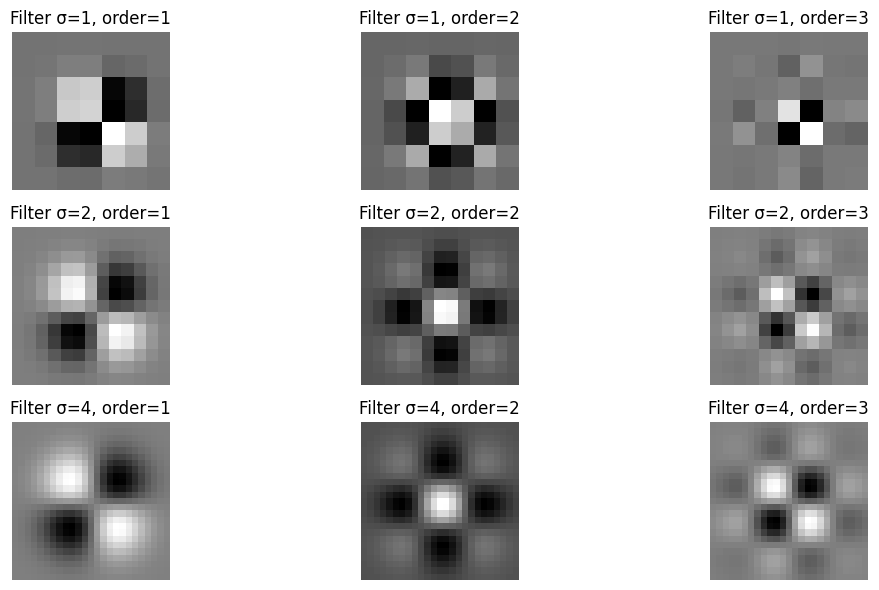

In [27]:
# Display the filters separately for better visualization
fig, axes = plt.subplots(len(scales), 3, figsize=(12, 6))

for i, (sigma, order, kernel) in enumerate(filters):
    row = i // 3
    col = i % 3
    kernel_2d = np.outer(kernel, kernel)  # Convert 1D kernel to 2D representation
    axes[row, col].imshow(kernel_2d, cmap='gray')
    axes[row, col].set_title(f"Filter σ={sigma}, order={order}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


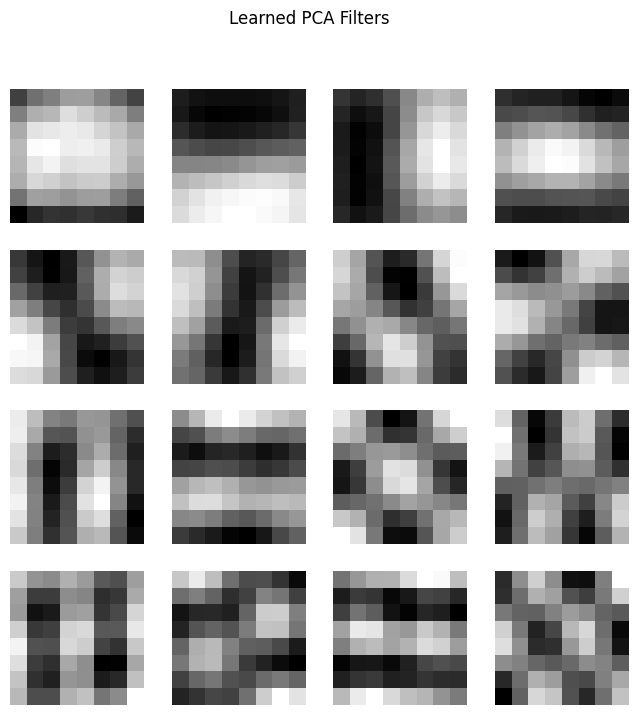

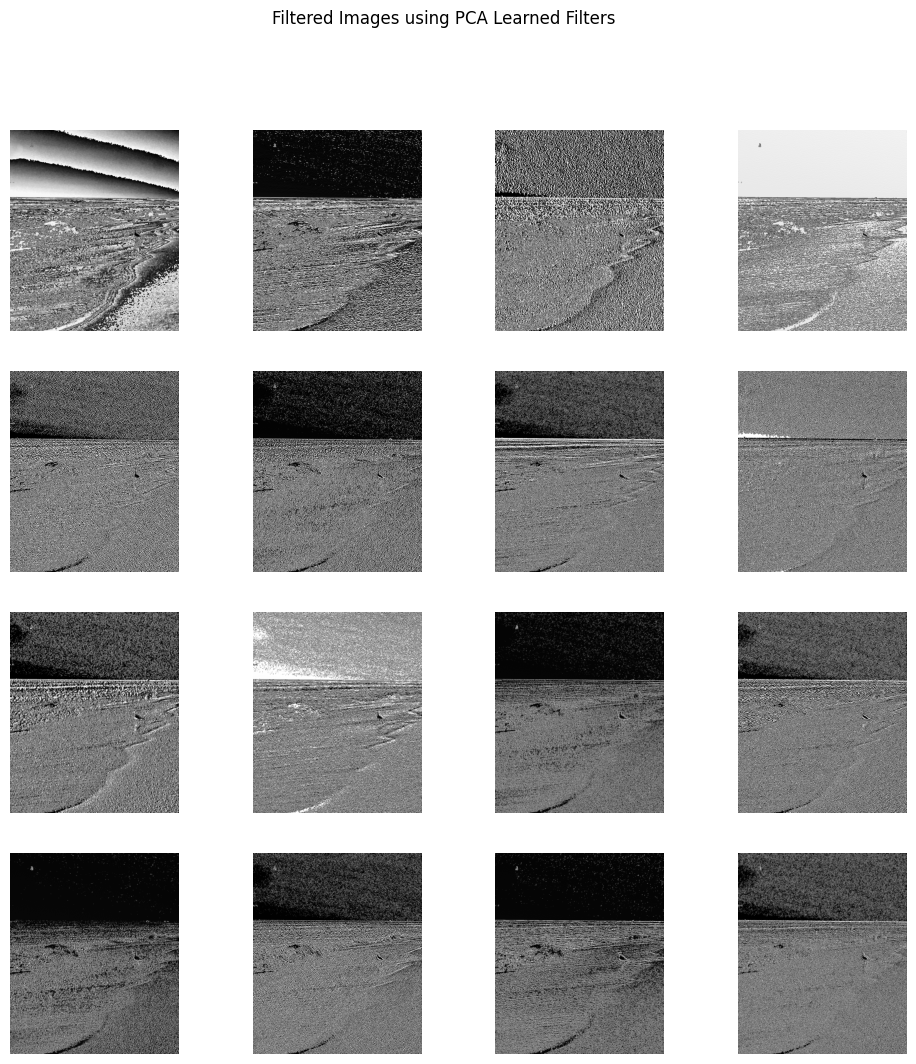

In [4]:


# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Extract 8x8 patches from the image
patch_size = (8, 8)
num_patches = 5000  # Number of patches to sample
patches = extract_patches_2d(image, patch_size, max_patches=num_patches, random_state=42)

# Reshape patches into vectors (flatten each 8x8 patch into a 64D vector)
patches = patches.reshape(patches.shape[0], -1)

# Perform PCA to learn filters
num_components = 16  # Number of filters to extract
pca = PCA(n_components=num_components)
pca.fit(patches)
filters = pca.components_.reshape((num_components, patch_size[0], patch_size[1]))

# Apply learned filters to the image
responses = []
for f in filters:
    response = ndimage.convolve(image, f, mode='reflect')
    responses.append(response)

# Visualize learned filters
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i], cmap='gray')
    ax.axis('off')
plt.suptitle("Learned PCA Filters")
plt.show()

# Visualize filtered images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(responses[i], cmap='gray')
    ax.axis('off')
plt.suptitle("Filtered Images using PCA Learned Filters")
plt.show()


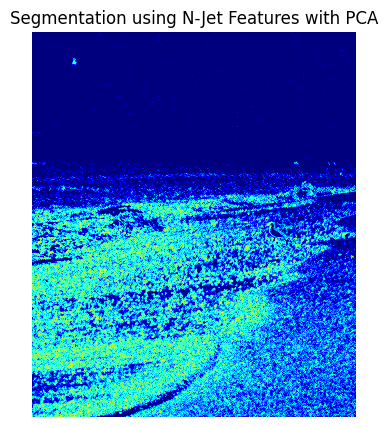

In [40]:


# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Function to apply a filter bank and extract features
def apply_filter_bank(image, filters):
    responses = [convolve(image, f) for f in filters]
    return np.stack(responses, axis=-1)  # Stack results along the channel dimension

# Generate N-Jet filters (Gaussian derivatives)
def gaussian_derivative_filters(sigma, order):
    size = int(6 * sigma + 1)
    size += 1 if size % 2 == 0 else 0
    x = np.linspace(-size//2, size//2, size)
    gaussian = np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    if order == 1:
        kernel = -x / (sigma**2) * gaussian
    elif order == 2:
        kernel = (x**2 - sigma**2) / (sigma**4) * gaussian
    elif order == 3:
        kernel = (x**3 - 3 * x * sigma**2) / (sigma**6) * gaussian
    else:
        raise ValueError("Only orders 1, 2, and 3 are supported")
    return kernel

# Create a filter bank using N-Jet filters
scales = [1, 2, 4]
filters = []
for sigma in scales:
    for order in [1, 2, 3]:
        kernel = gaussian_derivative_filters(sigma, order).reshape(-1, 1)
        filters.append(kernel @ kernel.T)  # Generate 2D filters

# Extract N-Jet features
njet_features = apply_filter_bank(image, filters)
njet_features = njet_features.reshape(-1, njet_features.shape[-1])  # Flatten for clustering

pca = PCA(n_components=3)
njet_features_pca = pca.fit_transform(njet_features)

kmeans_njet = KMeans(n_clusters=3, random_state=42, n_init=10).fit(njet_features_pca)
seg_njet = kmeans_njet.labels_.reshape(image.shape)

# Display segmentation results
plt.figure(figsize=(5, 5))
plt.imshow(seg_njet, cmap='jet')
plt.title("Segmentation using N-Jet Features with PCA")
plt.axis('off')
plt.show()


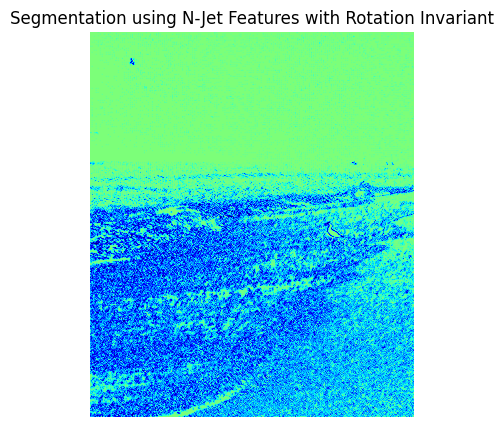

In [43]:

# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Function to apply a filter bank and extract features
def apply_filter_bank(image, filters):
    responses = np.array([convolve(image, f) for f in filters])
    return np.max(responses, axis=0)  # Compute max over all orientations (rotation invariant)

# Generate N-Jet filters (Gaussian derivatives)
def gaussian_derivative_filters(sigma, order):
    size = int(6 * sigma + 1)
    size += 1 if size % 2 == 0 else 0
    x = np.linspace(-size//2, size//2, size)
    gaussian = np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    if order == 1:
        kernel = -x / (sigma**2) * gaussian
    elif order == 2:
        kernel = (x**2 - sigma**2) / (sigma**4) * gaussian
    elif order == 3:
        kernel = (x**3 - 3 * x * sigma**2) / (sigma**6) * gaussian
    else:
        raise ValueError("Only orders 1, 2, and 3 are supported")
    return kernel

# Create a filter bank using N-Jet filters
scales = [1, 2, 4]
filters = []
for sigma in scales:
    for order in [1, 2, 3]:
        kernel = gaussian_derivative_filters(sigma, order).reshape(-1, 1)
        filters.append(kernel @ kernel.T)  # Generate 2D filters

# Extract rotation-invariant N-Jet features
njet_features = apply_filter_bank(image, filters)
njet_features = njet_features.reshape(-1, 1)  # Flatten for clustering

kmeans_njet = KMeans(n_clusters=3, random_state=42, n_init=10).fit(njet_features)
seg_njet = kmeans_njet.labels_.reshape(image.shape)

# Display segmentation results
plt.figure(figsize=(5, 5))
plt.imshow(seg_njet, cmap='jet')
plt.title("Segmentation using N-Jet Features with Rotation Invariant")
plt.axis('off')
plt.show()


Shape of njet_features before reshape: (1532, 1288, 9)
Shape after rotation invariant: (1532, 1288)
Final shape before PCA: (1973216, 1)


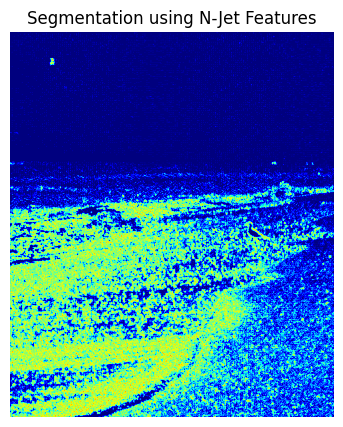

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.ndimage import convolve

# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Function to apply a filter bank and extract features
def apply_filter_bank(image, filters):
    responses = np.array([convolve(image, f) for f in filters])
    return np.stack(responses, axis=-1)  # Stack along last dimension (保持所有方向)

# Generate N-Jet filters (Gaussian derivatives)
def gaussian_derivative_filters(sigma, order):
    size = int(6 * sigma + 1)
    size += 1 if size % 2 == 0 else 0
    x = np.linspace(-size//2, size//2, size)
    gaussian = np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    if order == 1:
        kernel = -x / (sigma**2) * gaussian
    elif order == 2:
        kernel = (x**2 - sigma**2) / (sigma**4) * gaussian
    elif order == 3:
        kernel = (x**3 - 3 * x * sigma**2) / (sigma**6) * gaussian
    else:
        raise ValueError("Only orders 1, 2, and 3 are supported")
    return kernel

# Create a filter bank using N-Jet filters
scales = [1, 2, 4]
filters = []
for sigma in scales:
    for order in [1, 2, 3]:
        kernel = gaussian_derivative_filters(sigma, order).reshape(-1, 1)
        filters.append(kernel @ kernel.T)  # Generate 2D filters

njet_features = apply_filter_bank(image, filters)
print("Shape of njet_features before reshape:", njet_features.shape)

njet_features = np.max(njet_features, axis=-1)  # 或者 np.mean(njet_features, axis=-1)
print("Shape after rotation invariant:", njet_features.shape)  # 确保它仍然是 2D

njet_features = njet_features.reshape(-1, 1)  # (1532*1288, 1)
print("Final shape before PCA:", njet_features.shape)  # 确保它是 (pixels, features)

pca = PCA(n_components=1)  # 这里 n_features=1，PCA 只能降到 1
njet_features_pca = pca.fit_transform(njet_features)

kmeans_njet = KMeans(n_clusters=3, random_state=42, n_init=10).fit(njet_features_pca)
seg_njet = kmeans_njet.labels_.reshape(image.shape)  # 确保 reshape 正确

# Display segmentation results
plt.figure(figsize=(5, 5))
plt.imshow(seg_njet, cmap='jet')
plt.title("Segmentation using N-Jet Features")
plt.axis('off')
plt.show()


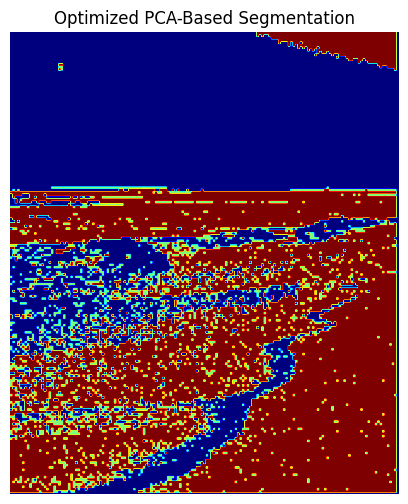

In [19]:

from sklearn.preprocessing import StandardScaler

# Load grayscale image
image_path = "../TestImages/Week 1/sunandsea.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Extract pixel-wise features using small patches
patch_size = 8  # Define patch size
h, w = image.shape
patches = []

# Extract patches with a sliding window
for i in range(0, h - patch_size, patch_size):
    for j in range(0, w - patch_size, patch_size):
        patch = image[i:i+patch_size, j:j+patch_size].flatten()
        patches.append(patch)

patches = np.array(patches)

image_blurred = cv2.GaussianBlur(image, (5, 5), 1)


# Apply PCA to extract meaningful features
pca = PCA(n_components=10, random_state=42)
pca_features = pca.fit_transform(patches)

# Normalize features for better clustering performance
scaler = StandardScaler()
pca_features = scaler.fit_transform(pca_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(pca_features)
labels = kmeans.labels_

# Map cluster labels back to the original image size
segmentation = np.zeros((h, w), dtype=np.uint8)
index = 0
for i in range(0, h - patch_size, patch_size):
    for j in range(0, w - patch_size, patch_size):
        segmentation[i:i+patch_size, j:j+patch_size] = labels[index]
        index += 1


kernel = np.ones((3, 3), np.uint8)
segmentation_cleaned = cv2.medianBlur(segmentation.astype(np.uint8), 3)

plt.figure(figsize=(6, 6))
plt.imshow(segmentation_cleaned, cmap='jet')
plt.title("Optimized PCA-Based Segmentation")
plt.axis('off')
plt.show()